In [1]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#import python packages for working with .cool, .bigwig and .gtf files
import cooler
import cooltools
import pyBigWig
from gtfparse import read_gtf

In [4]:
# import HiC in .cool or .mcool 
# note: if you are importing HiC in .mcool file, you should specify the resolution
clr = cooler.Cooler('inputs/GSE130275_mESC_WT_combined_2.6B_chr1_3200.cool')
resolution = clr.binsize
print(resolution)

3200


In [5]:
# computing the expected values for each diagonal in cis
view_df=pd.DataFrame({'chrom':clr.chromnames,
                      'start':0,
                      'end':clr.chromsizes.values,
                      'name':clr.chromnames})
expected = cooltools.expected_cis(clr, view_df=view_df, nproc=2, chunksize=1_000_000)
display(expected)

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr1,chr1,0,59366,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,chr1,1,58806,NaN,NaN,NaN,NaN,3.488489e-04,3.488489e-04
2,chr1,chr1,2,58741,8789487.0,1924.086881,149.631212,0.032755,2.977595e-02,2.977595e-02
3,chr1,chr1,3,58726,4892228.0,1065.963463,83.305997,0.018151,1.797350e-02,1.797350e-02
4,chr1,chr1,4,58723,3391091.0,738.562921,57.747237,0.012577,1.234306e-02,1.234306e-02
...,...,...,...,...,...,...,...,...,...,...
61080,chr1,chr1,61080,0,0.0,0.000000,NaN,NaN,3.737855e-07,3.737855e-07
61081,chr1,chr1,61081,0,0.0,0.000000,NaN,NaN,3.737819e-07,3.737819e-07
61082,chr1,chr1,61082,0,0.0,0.000000,NaN,NaN,3.737782e-07,3.737782e-07
61083,chr1,chr1,61083,0,0.0,0.000000,NaN,NaN,3.737746e-07,3.737746e-07


In [6]:
# import gene annotation in .gft file to extract gene/transcript information
df_gene0 = read_gtf("inputs/mm10.ensGene_chr1.gtf")
df_gene0 = df_gene0[df_gene0['feature']=="transcript"]
df_gene0 = df_gene0[['seqname','start','end','strand','gene_id']]
df_gene0['length'] = df_gene0['end']-df_gene0['start']
df_gene0 = df_gene0.sort_values('length', ascending=False).drop_duplicates('gene_id')
df_gene0 = df_gene0.rename(columns = {'seqname': 'chrom'}, inplace = False)
df_gene0 = df_gene0.sort_values(['chrom','start'])
display(df_gene0)

/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_name', 'exon_number', 'exon_id']


,chrom,start,end,strand,gene_id,length
0,chr1,3073253,3074322,+,ENSMUSG00000102693,1069
2,chr1,3102016,3102125,+,ENSMUSG00000064842,109
10,chr1,3214482,3671498,-,ENSMUSG00000051951,457016
21,chr1,3252757,3253236,+,ENSMUSG00000102851,479
23,chr1,3365731,3368549,-,ENSMUSG00000103377,2818
...,...,...,...,...,...,...
109529,chr1,195220051,195222766,-,ENSMUSG00000102236,2715
109531,chr1,195228278,195228398,+,ENSMUSG00000093823,120
109533,chr1,195240910,195241007,-,ENSMUSG00000099208,97
109535,chr1,195259299,195259848,-,ENSMUSG00000104297,549


In [7]:
# select a subset of genes based on size
# Note: the minimum size of the gene is better to be at least 20 times higher than HiC resolution
lmin = 20*resolution
lmax = 40*resolution
df_gene = df_gene0[(df_gene0['length']<lmax)&(df_gene0['length']>lmin)]
df_gene = df_gene.reset_index(drop=True)
display(df_gene)

,chrom,start,end,strand,gene_id,length
0,chr1,3905739,3986215,-,ENSMUSG00000102343,80476
1,chr1,4290846,4409241,-,ENSMUSG00000025900,118395
2,chr1,4807892,4886770,+,ENSMUSG00000104217,78878
3,chr1,5070018,5162340,+,ENSMUSG00000033793,92322
4,chr1,7088920,7173628,+,ENSMUSG00000051285,84708
...,...,...,...,...,...,...
195,chr1,185204117,185286759,+,ENSMUSG00000039318,82642
196,chr1,185363044,185428360,+,ENSMUSG00000026615,65316
197,chr1,186622792,186705989,-,ENSMUSG00000039239,83197
198,chr1,191717834,191784255,+,ENSMUSG00000026623,66421


In [8]:
# compute Intra-gene RNA Pol II (IR) score from PolII ChIP-seq data in BigWig format
pol2 = pyBigWig.open("inputs/GSM4173524_DMSO-N20-input_rep1_chr1.bw")
l = len(df_gene)
for i in range(l):
    ch = df_gene.chrom[i]
    start = df_gene.start[i]
    end = df_gene.end[i]
    df_gene.loc[i,'IR_score'] = np.mean(pol2.values(ch,start,end))
df_gene.loc[:,'log2_IR_score'] = np.log2(df_gene['IR_score'])

display(df_gene)

,chrom,start,end,strand,gene_id,length,IR_score,log2_IR_score
0,chr1,3905739,3986215,-,ENSMUSG00000102343,80476,0.274052,-1.867477
1,chr1,4290846,4409241,-,ENSMUSG00000025900,118395,0.251791,-1.989699
2,chr1,4807892,4886770,+,ENSMUSG00000104217,78878,4.901177,2.293128
3,chr1,5070018,5162340,+,ENSMUSG00000033793,92322,2.676813,1.420517
4,chr1,7088920,7173628,+,ENSMUSG00000051285,84708,1.395533,0.480816
...,...,...,...,...,...,...,...,...
195,chr1,185204117,185286759,+,ENSMUSG00000039318,82642,1.109796,0.150295
196,chr1,185363044,185428360,+,ENSMUSG00000026615,65316,3.483059,1.800355
197,chr1,186622792,186705989,-,ENSMUSG00000039239,83197,0.629080,-0.668684
198,chr1,191717834,191784255,+,ENSMUSG00000026623,66421,0.851465,-0.231981


In [9]:
# select genes based on IR scores
IRmin = 0
IRmax = 2
sub_df_gene = df_gene[(df_gene['log2_IR_score']<IRmax)&(df_gene['log2_IR_score']>IRmin)]
sub_df_gene = sub_df_gene.reset_index(drop=True)
display(sub_df_gene)

,chrom,start,end,strand,gene_id,length,IR_score,log2_IR_score
0,chr1,5070018,5162340,+,ENSMUSG00000033793,92322,2.676813,1.420517
1,chr1,7088920,7173628,+,ENSMUSG00000051285,84708,1.395533,0.480816
2,chr1,10038217,10136768,+,ENSMUSG00000056763,98551,2.405323,1.266231
3,chr1,10137571,10232670,-,ENSMUSG00000067851,95099,1.302765,0.381577
4,chr1,16540790,16619312,-,ENSMUSG00000025939,78522,1.542900,0.625645
5,chr1,30802339,30873581,-,ENSMUSG00000048874,71242,2.873952,1.523036
6,chr1,36140027,36244305,-,ENSMUSG00000037470,104278,1.891351,0.919417
7,chr1,36562692,36683183,-,ENSMUSG00000046337,120491,1.214913,0.280853
8,chr1,39371492,39478755,-,ENSMUSG00000003134,107263,2.979552,1.575096
9,chr1,39900913,40026310,+,ENSMUSG00000026074,125397,2.898297,1.535206


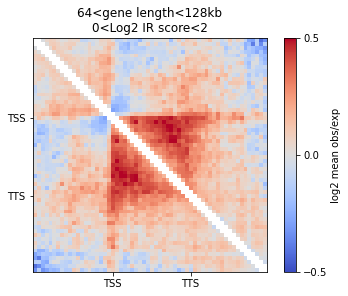

In [11]:
# pileup mtea-gene analysis (PMGA) of intra-gene HiC contact map
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),constrained_layout = True)
def get_row_compressor(old_dimension, new_dimension):
    dim_compressor = np.zeros((new_dimension, old_dimension))
    bin_size = float(old_dimension) / new_dimension
    next_bin_break = bin_size
    which_row = 0
    which_column = 0
    while which_row < dim_compressor.shape[0] and which_column < dim_compressor.shape[1]:
        if round(next_bin_break - which_column, 10) >= 1:
            dim_compressor[which_row, which_column] = 1
            which_column += 1
        elif next_bin_break == which_column:

            which_row += 1
            next_bin_break += bin_size
        else:
            partial_credit = next_bin_break - which_column
            dim_compressor[which_row, which_column] = partial_credit
            which_row += 1
            dim_compressor[which_row, which_column] = 1 - partial_credit
            which_column += 1
            next_bin_break += bin_size
    dim_compressor /= bin_size
    return dim_compressor


def get_column_compressor(old_dimension, new_dimension):
    return get_row_compressor(old_dimension, new_dimension).transpose()

def compress_and_average(array, new_shape):
    # Note: new shape should be smaller in both dimensions than old shape
    return np.mat(get_row_compressor(array.shape[0], new_shape[0])) * \
           np.mat(array) * \
           np.mat(get_column_compressor(array.shape[1], new_shape[1]))

sub_df_gene['mid'] = sub_df_gene['end']
sub_df_gene['start'] = sub_df_gene['end']-1
sub_df_gene['end'] = sub_df_gene['end']+1
flank = 2*max(sub_df_gene.length)
stack = cooltools.pileup(clr, sub_df_gene, view_df=view_df, expected_df=expected, flank=flank)
lm = sub_df_gene.length[0]//resolution
fm = flank//resolution
m1 = fm-2*lm
m2 = fm+lm
mtx0 = stack[m1:m2,m1:m2,0]
stk = np.asarray(compress_and_average(mtx0, (60, 60)))
l = len(sub_df_gene)
for i in range (1,l):
    lm = sub_df_gene.length[i]//resolution
    m1 = fm-2*lm
    m2 = fm+lm
    mtx0 = stack[m1:m2,m1:m2,i]
    mtx0 = np.asarray(compress_and_average(mtx0, (60, 60)))
    stk = np.dstack((stk,mtx0))
mask = np.array(sub_df_gene.strand == '-', dtype=bool)
stk[:, :, mask] = stk[::-1, ::-1, mask]
mtx = np.nanmean(stk, axis=2)

np.fill_diagonal(mtx, np.nan)
lm = len(mtx)-1
for i in range(lm):
    mtx[i,i+1] = np.nan
    mtx[i+1,i] = np.nan

im = ax.imshow(
    np.log2(mtx),
    vmax = 0.5,
    vmin = -0.5,
    cmap='coolwarm',
    interpolation='none')

plt.colorbar(im,label = 'log2 mean obs/exp',ticks=[-0.5, 0, 0.5])
ticks_pixels = [20,40]
ticks_labels = ['TSS','TTS']
ax.set_xticks(ticks_pixels)
ax.set_xticklabels(ticks_labels)
ax.set_yticks(ticks_pixels)
ax.set_yticklabels(ticks_labels)
ax.set_title(str(lmin//1000)+'<gene length<'+str(lmax//1000)+'kb\n'
          +str(IRmin)+'<Log2 IR score<'+str(IRmax))
np.savetxt('outputs/PMGA_intragene_HiC.txt', mtx, fmt='%f')
fig.savefig("outputs/PMGA_intragene_HiC.png")